In [44]:

# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD# !curl 

In [45]:
import pandas as pd


In [47]:
counts = pd.read_csv('C:/Users/tianjiayang/data_science_101/Predicting Bicycle Traffic/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('C:/Users/tianjiayang/data_science_101/Predicting Bicycle Traffic/BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [48]:
print(counts.head())
print(counts.shape)

                     Fremont Bridge East Sidewalk  \
Date                                                
2012-10-03 00:00:00                           9.0   
2012-10-03 01:00:00                           6.0   
2012-10-03 02:00:00                           1.0   
2012-10-03 03:00:00                           3.0   
2012-10-03 04:00:00                           1.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2012-10-03 00:00:00                           4.0  
2012-10-03 01:00:00                           4.0  
2012-10-03 02:00:00                           1.0  
2012-10-03 03:00:00                           2.0  
2012-10-03 04:00:00                           6.0  
(50328, 2)


In [80]:
weather.head()

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03,Temp (C),dry day
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0.000000,0,0,12.8,5.0,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,8.90,1
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0.429134,0,0,10.6,2.8,45,180,200,...,-9999,-9999,-9999,1,1,-9999,-9999,-9999,6.70,0
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0.031496,0,0,11.7,7.2,23,180,170,...,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999,9.45,0
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0.799213,0,0,12.2,5.6,47,180,190,...,-9999,-9999,-9999,1,1,-9999,-9999,-9999,8.90,0
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0.051181,0,0,8.9,2.8,61,200,220,...,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999,5.85,0


计算每一天的自行车流量，放到一个新的df中

In [50]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

我们认为周中vs周末，会对车流量造成影响，因此加入关于这个的特征

In [51]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [52]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


我认为节假日与否同样会对此造成影响

In [53]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [54]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


我还认为，当天的白天长短会影响骑车流量

(8, 17)

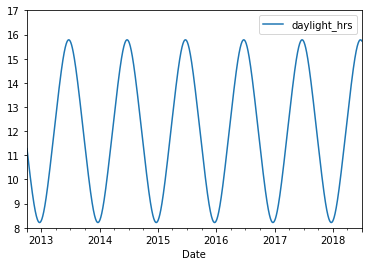

In [55]:
import numpy as np
import matplotlib.pyplot as plt
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

平均气温和当天下雨与否，雨下的多大势必也有影响

In [56]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10

#当天平均气温
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# 降雨量
weather['PRCP'] /= 254

#是否下雨
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [57]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0


In [67]:
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

In [72]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept = False)
model.fit(X,y)
daily['predicted'] = model.predict(X)

查看我们的拟合情况

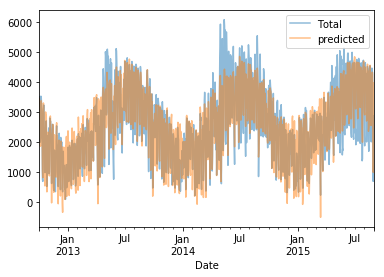

In [73]:
daily[['Total','predicted']].plot(alpha=0.5)

可见整体拟合情况还算良好，但是在夏天的时候表现较差，猜测我们仍然需要更多的特征来刻画xy之间的关系

此外，有可能存在一些非线性关系影响流量（如人们在温度过高或者过低时都不愿意骑车等）

In [79]:
from sklearn.metrics import r2_score
print("r2_score评分：",r2_score(y,daily['predicted']))

r2_score评分： 0.867535871995


In [75]:
params = pd.Series(model.coef_,index = X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs     128.851511
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [76]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_ for i in range(1000)],0)

In [77]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs   129.0    9.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


星期的特征较为明显， 工作日肯定比周末骑车的人要多

其次， 当白天时长每增加一小时，骑车的人就会多129±9个

而，当降雨量增加1英寸， 骑车人数就会减少 665±62个人 等等



反思不足之处：

1）非线性因素（如降雨和寒冷的天）

2）非线性趋势（温度过高或过低不愿意骑车）

3）丢失了一些较小粒度的数据（如下雨天的早晨和下雨天的半晚的差异，在早上一小时下了很大的雨（高降水量）后一天天气适宜万里无云的情况）

4）日期相关性（例如下雨的周二对周三骑车人数的影响）